# Supplementary Figures

This notebook recreates the supplementary figures of Lee et al. 2021. 



### Description of the Data

The data used in this notebook comes from the exepriments described in Lee et al. 2021. Specifically, we have the behavioral and activity of a trained deep RL agent performing a evidence accumulation task from Engelhard et al. 2019. 

The dataset includes 5000 trials of the trained agent with frozen weights. 

The relevant variables included are: 


## Preparing the Data
### Importing required code packages and modules

In [1]:
cd ..

/Users/sasha/Documents/towers_mice


In [2]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import sys
from scipy.io import loadmat, savemat
import towers_mice_dqn.cnnlstm_analysis_utils as utils
import seaborn as sns
from scipy import stats
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import os

Missing colon in file '/Users/sasha/.matplotlib/matplotlibrc', line 1 ('~/.matplotlib/matplotlibrc')


### downloading data

In [3]:
load_prefix = './data/logs/VA_maze/'
with open(load_prefix + '5000t_mosttrain_db.p', 'rb') as f:
     [actions_, rewards_, feats_, terms_, vs_, tow_counts_, episode_lengths, ypos_]  = pickle.load(f)
f.close()
vs = np.hstack(vs_)
terms = np.hstack(terms_)
rewards = np.hstack(rewards_)
ep_rew = np.array([np.sum(r_trial) for r_trial in rewards_])
ep_tow = np.array([np.max(trial, 0) for trial in tow_counts_])
tow_counts = np.vstack(tow_counts_)



weights = utils.get_params_from_zip(load_prefix + 'rl_model_20800000_steps')
# weights.keys()

w_pol = weights['model/pi/w:0']
b_pol = weights['model/pi/b:0']
w_val = np.squeeze(weights['model/vf/w:0'])
b_val = weights['model/vf/b:0']

trial_info = loadmat(load_prefix + 'trialinfo_db.mat')

trial_info = trial_info['trials']
trial_info.dtype.names
choices = utils.extract_field(trial_info, 'choice')
trial_type = utils.extract_field(trial_info, 'trialType')
raw_ypos = utils.extract_field(trial_info, 'position')[:,1]
cueCombos_ = utils.extract_field(trial_info, 'cueCombo')
cuePos_ = utils.extract_field(trial_info, 'cuePos')
cueOnset_ = utils.extract_field(trial_info, 'cueOnset')
raw_ypos_ = [x[:,1] for x in trial_info['position'][0]]
raw_xpos_ = [x[:,0] for x in trial_info['position'][0]]
raw_vpos_ = [x[:,2] for x in trial_info['position'][0]]
ypos_ = [np.hstack([np.array(x[:-1]), x[-2] * np.ones((7,))]) for x in raw_ypos_]
ypos = np.hstack(ypos_)


### Plotting Parameters

In [4]:
# PLOTTING PARAMS
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams.update({'font.family': 'Arial'})

FONT_BG = 25
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # allow text of pdf to be edited in illustrator

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

marker_plots =  {'marker':'.', 'markersize':2, 'markeredgecolor':'k', 'markerfacecolor':'k'}

from matplotlib.colors import ListedColormap


### Organizing Data

Pulling out the specific data that we will use for figure panels

In [5]:
CUEP_LIM = 140
REWP_LEN_S = -16
REWP_LEN_STP = -5
ypos_cuep = np.squeeze(np.dstack([ypos_t[:CUEP_LIM] for ypos_t in ypos_])[:,:,0])
(ep_towdelt_idx, ep_towdiff_idx) = utils.get_ep_tow_idx(ep_tow)
ep_rewidx = (episode_lengths - 11).astype(int)


### Calculate Vector RPEs

In [6]:
if os.path.exists(load_prefix + 'pes.p'):
    with open(load_prefix + 'pes.p', 'rb') as f:
         pes  = pickle.load(f)
    f.close()

else: 
    feats = np.vstack(feats_)
    rewards = np.hstack(rewards_)
    terms = np.hstack(terms_)
    start = np.roll(terms,1)
    nsteps = len(terms)
    nfeatures = feats_[0][0].shape[0]
    gamma = 0.99
    # compute per-feature PEs
    pes = np.zeros((nsteps, nfeatures))
    for i in range(0,nsteps-1):
        if (terms[i]): # there is a one-off error-- the SECOND index of the start of the trial accurately measures the start of the trial
            pes[i,:] = rewards[i] / nfeatures -  w_val * feats[i,:]
        else:
            pes[i,:] = rewards[i] / nfeatures +  w_val * (-feats[i,:] + gamma * feats[i+1,:])

    pickle.dump(pes, open(load_prefix + "pes.p", "wb") )


# summing pes to get scalar
pes_sum = np.sum(pes,1)
# scalar pes binned by position
pes_sum_ = utils.split_by_ep_len(pes_sum, np.hstack((episode_lengths)))
# pes split by 5000 trials
pes_ = utils.split_by_ep_len(pes, np.hstack((episode_lengths)))

pes_sum_rewp = np.vstack([trial[rew_idx - 5:rew_idx + 6] for [trial, rew_idx] in zip(pes_sum_, ep_rewidx)])
pes_rewp = np.dstack([pes_i[rew_idx - 5:rew_idx + 6,:] for [pes_i, rew_idx] in zip(pes_, ep_rewidx)])
vs_rewp = np.vstack([pes_i[rew_idx - 5:rew_idx + 6] for [pes_i, rew_idx] in zip(vs_, ep_rewidx)])

pes_rewp_norm = utils.norm_within_feat(pes_rewp.transpose((1, 0, 2)).reshape(64, 11 * 5000)).reshape(64, 11, 5000).transpose(1, 0, 2)


In [8]:
# EASY VS HARD TRIALS AND RESPONSES

rew_trials = np.where(ep_rew == 1)[0]
nrew_trials = np.where(ep_rew == 0)[0]
easy_trials = np.hstack(ep_towdelt_idx[5:])
hard_trials = np.hstack(ep_towdelt_idx[:2])

rew_hard = np.sort(list(set(rew_trials) & set(hard_trials)))
rew_easy = np.sort(list(set(rew_trials) & set(easy_trials)))

norm_easy = (np.mean(pes_rewp_norm[:,:,rew_easy], -1).T)[:,5]
norm_hard = (np.mean(pes_rewp_norm[:,:,rew_hard], -1).T)[:,5]

## Extended Data 1: LSTM Feature Units Tuning

In [40]:
CUEP_LIM_FEAT = 150
feats_cuep = np.dstack([feats_i[:CUEP_LIM_FEAT] for feats_i in feats_]).transpose([0, 2, 1])

ep_towdiff_within = np.vstack([ep_tow_i[:CUEP_LIM_FEAT,0] - ep_tow_i[:CUEP_LIM_FEAT,1] for ep_tow_i in tow_counts_]).T


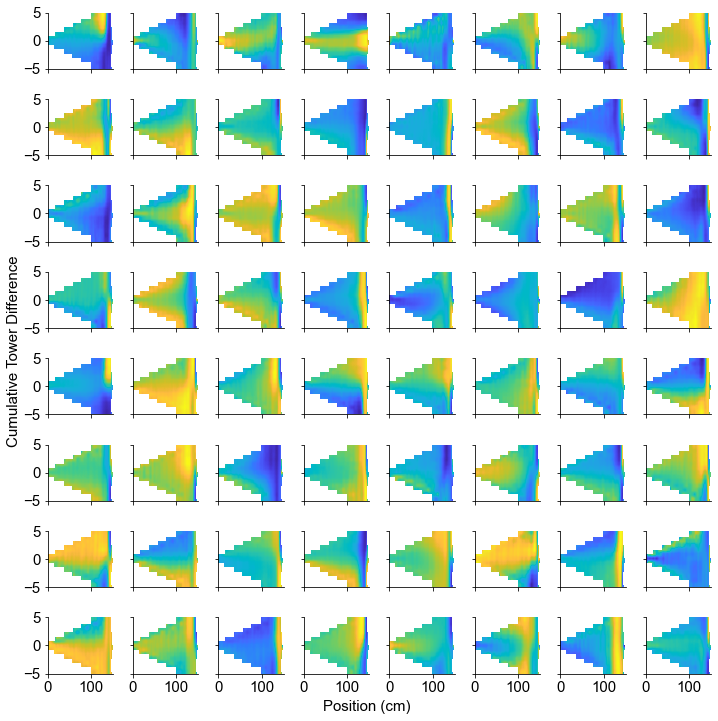

In [49]:

fig, axes = plt.subplots(figsize=(10,10), ncols=8, nrows = 8, sharex = True, sharey = True)
feats_axes = axes.flatten()
feats_by_posev = [];
for num_feat, feat_i in enumerate(feats_cuep.T):

    feat_by_posev = np.vstack([[np.mean(feat_i[np.where(ep_towdiff_within[i,:] == ev)[0],i])
                if ev in ep_towdiff_within[i,:] else np.nan
                for ev in  np.arange(-6,7)]
                for i in np.arange(CUEP_LIM_FEAT)]).T
    feats_by_posev.append(feat_by_posev)
    feats_axes[num_feat].imshow(feat_by_posev, aspect = 'auto',extent = [0, CUEP_LIM_FEAT,-5, 5], cmap = utils.parula_map) 

fig.text(0.5, 0, 'Position (cm)', ha='center')
fig.text(0, 0.5, 'Cumulative Tower Difference', va='center', rotation='vertical')
plt.tight_layout()

## Extended Data 2: Scalar RPE modulated by difficulty of task

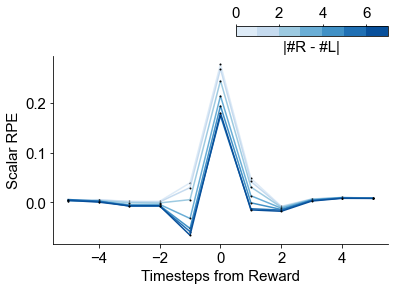

In [38]:

fig = plt.figure()
gs = gridspec.GridSpec(2,2,height_ratios = [0.05,1])

ax_sum = plt.subplot(gs[1,:])
colors = sns.color_palette("Blues", n_colors = 7)

for ep_towdelt in np.arange(len(ep_towdelt_idx)):
    rew_difficulty = np.sort(list(set(rew_trials) & set(ep_towdelt_idx[ep_towdelt])))
    ax_sum.plot(np.arange(-5,6),np.sum(np.nanmean(pes_rewp[:,:,rew_difficulty],-1),-1),
                                **marker_plots, color = colors[ep_towdelt],  label = 'delt:' + str(ep_towdelt));


ax_sum.set_xlabel('Timesteps from Reward')
ax_sum.set_ylabel('Scalar RPE')
# code for showing a colorbar
cmap = ListedColormap(colors.as_hex())
bounds = np.arange(8)
norm = matplotlib.colors.BoundaryNorm(boundaries = bounds, ncolors = 7)


lax = plt.subplot(gs[0,1])
dummy_plot = lax.scatter(bounds, bounds, c = bounds, cmap = cmap, norm = norm)
lax.cla()
cbar = plt.colorbar(dummy_plot, orientation='horizontal',cax = lax, ticks = [0, 2, 4, 6])
cbar.ax.tick_params(length = 2.5)

cbar.ax.xaxis.set_ticks_position("top")
cbar.set_label('|#R - #L|')
